Importing libraries. These libraries also form the prerequisites for running the notebook.

In [12]:
import os
import sys
import numpy as np
import re
import cv2 # To perform operations on images
import matplotlib.pyplot as plt # To plot our images
import tensorflow as tf # The machine learning framework

Setting os directories

In [13]:
train_path = os.curdir + '/Dataset/train' # The train directory
test_path = os.curdir + '/Dataset/test' # The test directory

The data loader:

In [14]:
def load_data_batch(img_path, mask_path, batch_size=32, shape=128):
    img_names = os.listdir(img_path) # Getting the list of images in the directory
    img_addr = img_path + '/'
    mask_addr = mask_path + '/'

    # The lists for images and the corresponding masks
    img_list = [] 
    mask_list = []

    for name in img_names:
        try:
            # Differentiating between masked images and train images, as they are in the same folder
            if str(img_addr+name).endswith('_mask.png'):
                img = plt.imread(img_addr + name.replace('_mask.png', '_sat.jpg'))
            else:
                img = plt.imread(img_addr + name)
            mask = plt.imread(mask_addr + name.replace('_sat.jpg', '_mask.png'))

        except Exception as e:
            print(f"Error loading image or mask for {name}: {e}")
            continue

        img = cv2.resize(img, (shape, shape)) # Resizing the image
        mask = cv2.resize(mask, (shape, shape))[:, :, 0]  # Take only the first channel, as the mask is binary (black and white)

        img_list.append(img)
        mask_list.append(mask)

        if len(img_list) == batch_size:
            yield tf.convert_to_tensor(img_list), tf.convert_to_tensor(mask_list) # Using yield, to create a generator
            img_list = []
            mask_list = []

    # Yield the remaining data as the last batch
    if img_list:
        yield tf.convert_to_tensor(img_list), tf.convert_to_tensor(mask_list)

In [15]:
data_loader = load_data_batch(train_path, train_path) # The final data loader

Plotting a random satellite image and its mask

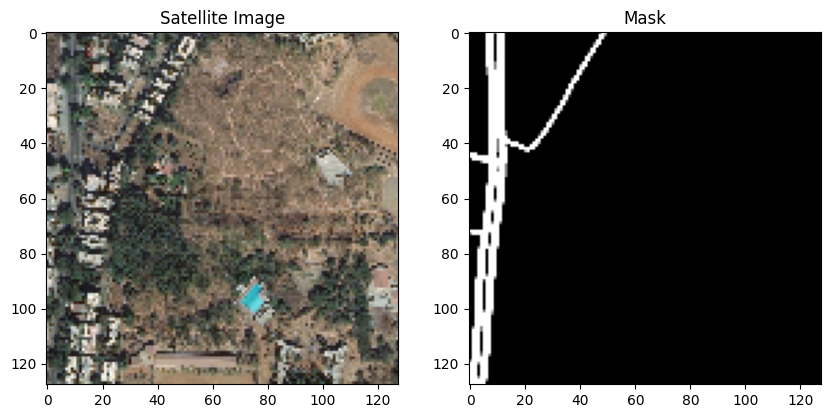

In [16]:
for images, masks in data_loader:
    # Randomly select an index from the batch
    idx = np.random.randint(0, len(images))

    image = images[idx]
    mask = masks[idx]

    # Plot the satellite image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Satellite Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

    plt.show()
    
    break

A function to create the model. Our model consists of the following layers:
1. Encoder: VGG-19, a widely known image net.
2. Decoder: Transposed Convolutional Layers, that up-sample data.
3. Skip Connections: In accordance with the U-NET paper, we also add skip connections between each encoder and decoder, in the same hierarchy.

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_unet(input_shape=(128, 128, 3)):
    # Encoder (VGG19)
    base_model = tf.keras.applications.VGG19(
        include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling=None
    )

    # Use the activations of the following layers for skip connections
    layer_names = [
        'block1_conv2', 'block2_conv2', 'block3_conv4', 'block4_conv4'
    ]
    layers_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the encoder model
    encoder = tf.keras.models.Model(inputs=base_model.input, outputs=layers_outputs, name='encoder')

    # Decoder
    input_tensor = tf.keras.Input(shape=input_shape, name='input')
    encoder_outputs = encoder(input_tensor)

    x = encoder_outputs[-1] 

    for i in range(1, 4):
        x = layers.Conv2DTranspose(256 / (2 ** i), (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
        x = layers.Concatenate()([x, encoder_outputs[-(i + 1)]])  # Concatenate with skip connection

    x = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)  # Output layer with sigmoid activation for binary classification

    # Create the U-Net model
    model = tf.keras.models.Model(inputs=input_tensor, outputs=x, name='vgg19_unet')

    return model


In [18]:
model = create_unet()
model.summary() # Seeing all the parameters 

Model: "vgg19_unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Functional)           [(None, 128, 128, 6  10585152    ['input[0][0]']                  
                                4),                                                               
                                 (None, 64, 64, 128                                               
                                ),                                                                
                                 (None, 32, 32, 256                                      

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='UnetArchitecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Define loss function and optimizer
loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Set up training loop
num_epochs = 10
batch_size = 32

The training loop:

In [ ]:
history = []

for i in range(num_epochs):
    data_loader = load_data_batch(train_path, train_path) # Creating a data loader
    acc = model.fit(data_loader, epochs=num_epochs) # Fitting the model
    history.append(acc) # Appending accuracy to a list, to plot a graph later

In [ ]:
model.save('C:/Users/shash/OneDrive/Desktop/College/Machine Learning/Extracting Topographical Features/model/') # Saving the model

In [ ]:
# model.load('C:/Users/shash/OneDrive/Desktop/College/Machine Learning/Extracting Topographical Features/model/') # To load the model later on

Picking a random satellite image, getting the mask from the model, and then comparing to the true mask

In [ ]:
data_loader = load_data_batch(train_path, train_path)
for images, masks in data_loader:
    # Randomly select an index from the batch
    idx = np.random.randint(0, len(images))
    image = images[idx]
    true_mask = masks[idx]

    # Make predictions
    predicted_mask = model.predict(np.expand_dims(image, axis=0))

    # Plot the satellite image, true mask, and predicted mask
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(image))
    plt.title('Satellite Image')

    # True Mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Mask')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_mask), cmap='gray') 
    plt.title('Predicted Mask')

    plt.show()

    break